# Time Series Analysis with TDA
gaussian data from 22-12-14
First, import the usual libraries

In [39]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import *#PersistenceImage, BettiCurve, Landscape, Entropy
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib widget

Now we load the data.
We have five machines, for each of which we have time series for working well and for malfunctioning.
This way we get 10 numpy arrays in total.

In [2]:
datapath =".\\data\\timeseries\\Data_14122022\\"
data = np.loadtxt(datapath+"signal_alpha1_8.txt")

good_time_series = [data[-1]]
bad_time_series = [data[i] for i in range(0,len(data)-1)]
print(data.shape)

(21, 50000)


In [3]:
data[10]

array([-1.7325428 , -1.6019487 ,  0.5750471 , ..., -1.3615292 ,
       -0.76493119,  0.94198643])

Let us plot the time series

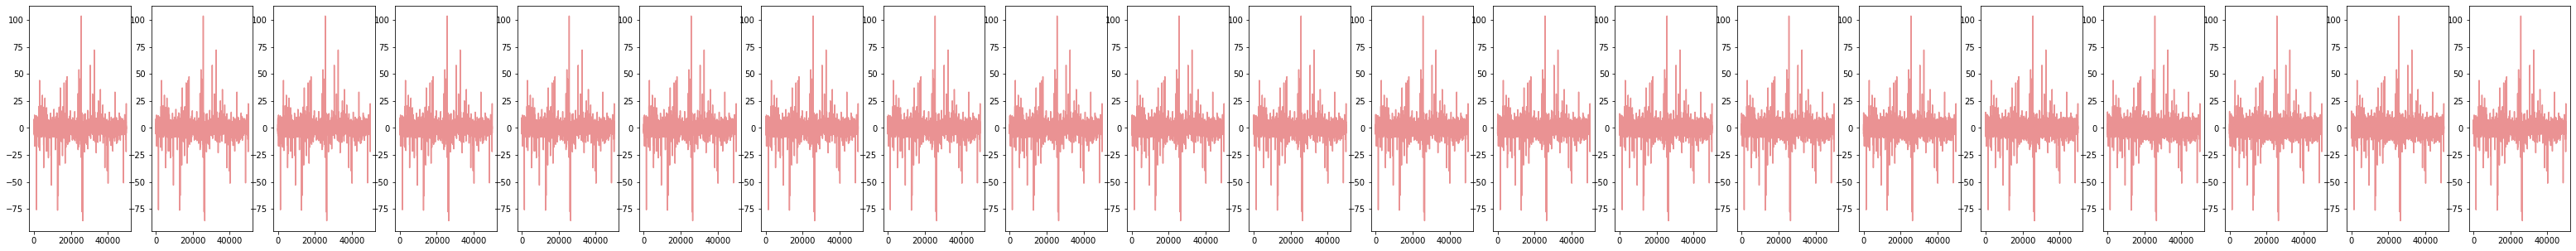

In [4]:
f,axes = plt.subplots(1,len(data), figsize = (55,5))
for i in range(0,len(data)):
    #axes[i].plot(np.array(range(len(good_time_series[i]))),good_time_series[i], alpha = 1, c="tab:green")
    #axes[i].plot(np.array(range(len(bad_time_series[i]))),bad_time_series[i], alpha=1, c="tab:red")
    axes[i].plot(np.array(range(len(data[i]))),data[i], alpha=0.5, c="tab:red")
plt.show()

Now we use time delay embedding, mapping a time series valued in $\mathbb{R}$ to a point cloud in $\mathbb{R}^4$.
The parameters are determined by trial and error.
Concretely, using $dim =4, delay = 5, skip = 6$, we map the sequence
$$(x_1, x_2, x_3, x_4, x_5, x_6, \ldots)\mapsto ((x_1, x_6, x_{11}, x_{16}), (x_7,x_{12}, x_{17},x_{22}),(x_{13},x_{18},x_{23},x_{28})).$$

In [217]:
#dim * delay should roughly equal len(time_series)/numer_of_periods
dim = 5*833# half period
delay = len(good_time_series[0])//dim
print("delay", delay)
skip = 1#200#0#100
print(dim*delay)
print(len(good_time_series[0])/24)

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
point_clouds = tde.transform(data)

for i in range(0,len(point_clouds)):
    point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
    point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]
    
print(np.array(point_clouds).shape)
print(len(point_clouds[0]))

delay 12
49980
2083.3333333333335
(21, 32, 4165)
32


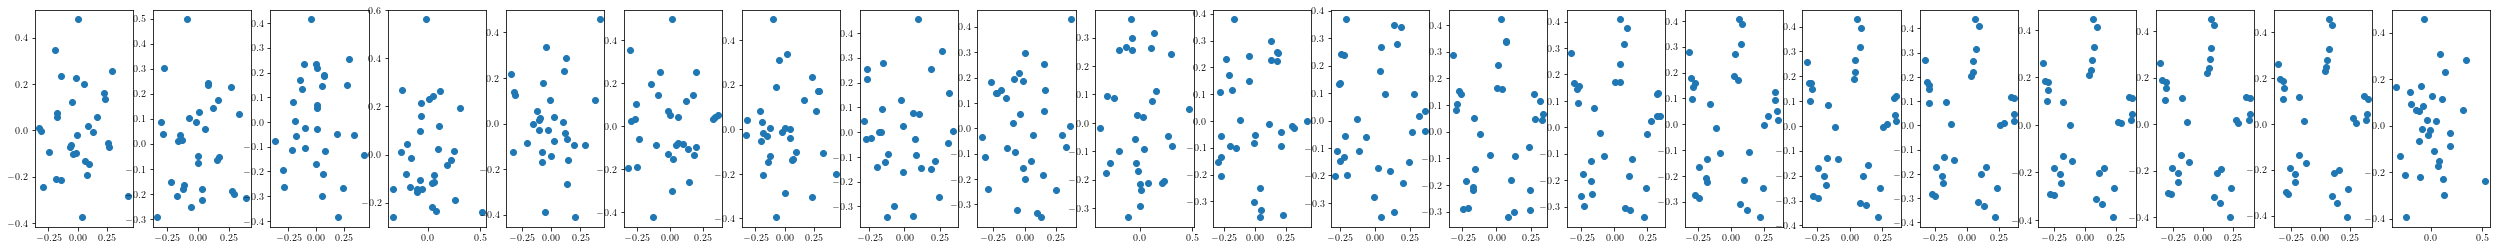

In [218]:
f,axes = plt.subplots(1,len(point_clouds), figsize = (44,4))
pca = PCA(n_components=2)
for i in range(0,len(point_clouds)):
    emb = pca.fit_transform(point_clouds[i])
    axes[i].scatter(emb[:,0],emb[:,1])
    

plt.show()

For each pointcloud, we compute persistent homology in dimension 1 using the alpha filtration.

In [219]:
pds = []

for pc in point_clouds:
    dist = cdist(pc,pc)
    dtm = DistanceToMeasure(10, metric="precomputed")
    r = dtm.fit_transform(dist)
    ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    pds.append(pd)

Now we plot the persistence diagrams.
The five pictures correspond to the five machines.
In each subfigure, the red diagram represents the well-working machine, whereas the green diagram represents the malfunctioning machine.

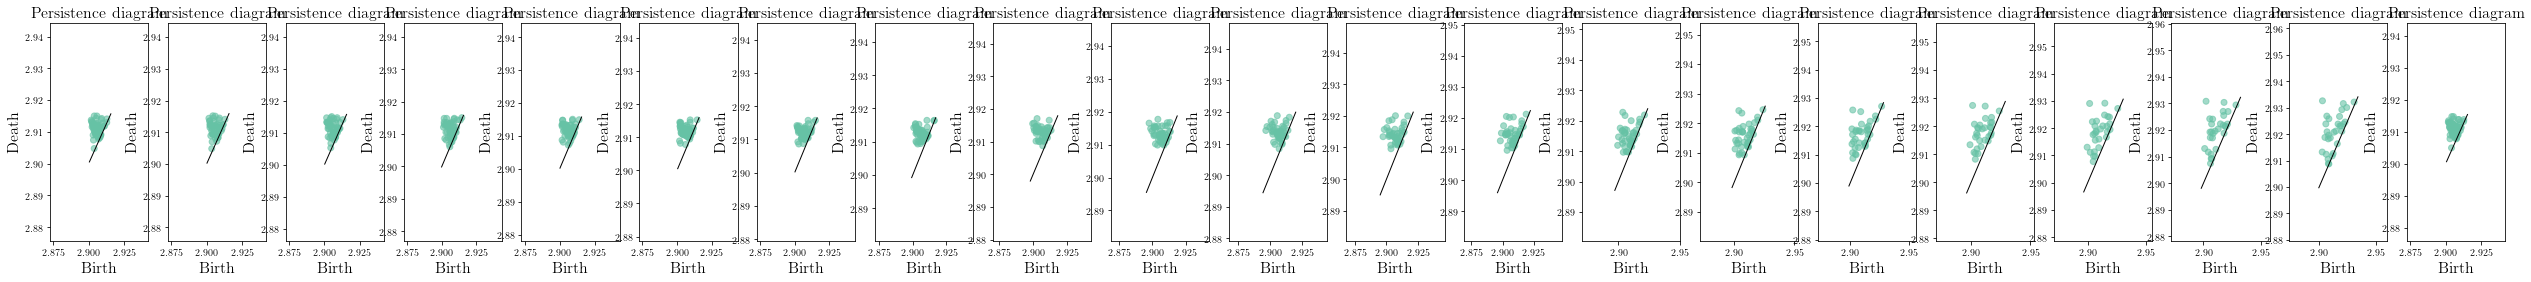

In [220]:
f,axes = plt.subplots(1,len(pds), figsize = (44,4))
for i in range(0,len(pds)):
    
    gd.plot_persistence_diagram(pds[i], axes=axes[i],colormap=cm.Set2.colors, greyblock=False)
    #gd.plot_persistence_diagram([good_pds[i], bad_pds[i]], axes=axes[i])
    axes[i].set_xlim((np.min(pds[i][:,0]*0.99),np.max(pds[i][:,0]*1.01)))
    axes[i].set_ylim((np.min(pds[i][:,1]*0.99),np.max(pds[i][:,1]*1.01)))
#plt.savefig("data221214_alpha18_PD1_densityR_delay{}_dim{}.pdf".format(delay,dim))
plt.show()

In [221]:
n=2
n_most_persistent_points = np.zeros((len(pds), n))
for i in range(0, len(pds)):
    lifetimes = pds[i][:,1]-pds[i][:,0]
    n_most_persistent_points[i] = lifetimes[np.argpartition(-lifetimes,n)[:n]]



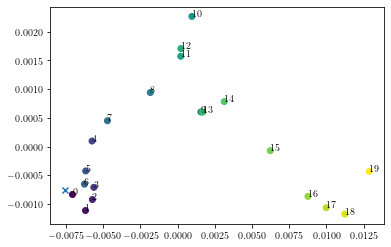

In [222]:
f,ax = plt.subplots()
pca = PCA(n_components=2)
emb =  pca.fit_transform(n_most_persistent_points)
t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):
    
    ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")

#ax.legend()
plt.show()

2.8937646958147916 2.9355510808584424


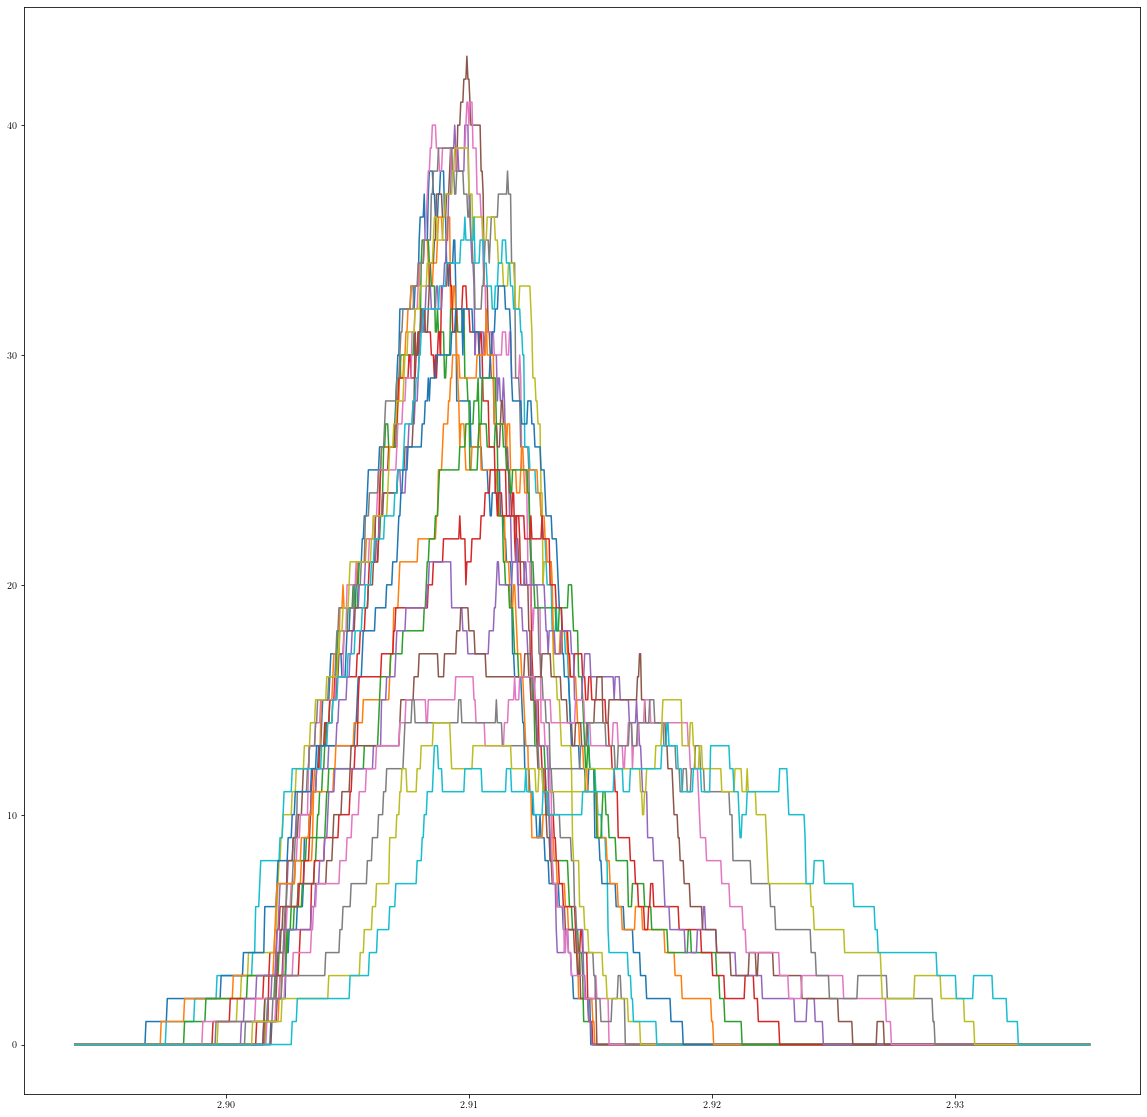

In [223]:
start = min([np.min(d) for d in pds])*0.999
end = max([np.max(d) for d in pds])*1.001
print(start,end)
x = np.linspace(start,end,1000)
bc = BettiCurve(predefined_grid=x)
betti_curves = bc.fit_transform(pds)

f,ax = plt.subplots(figsize=(20,20))
for i in range(0,len(pds)-1):
    ax.plot(x,betti_curves[i])
plt.show()

To do machine learning, we vectorize the diagrams to peristent images.
For illustration, we plot the PI corresponding to Machine 1 working well.

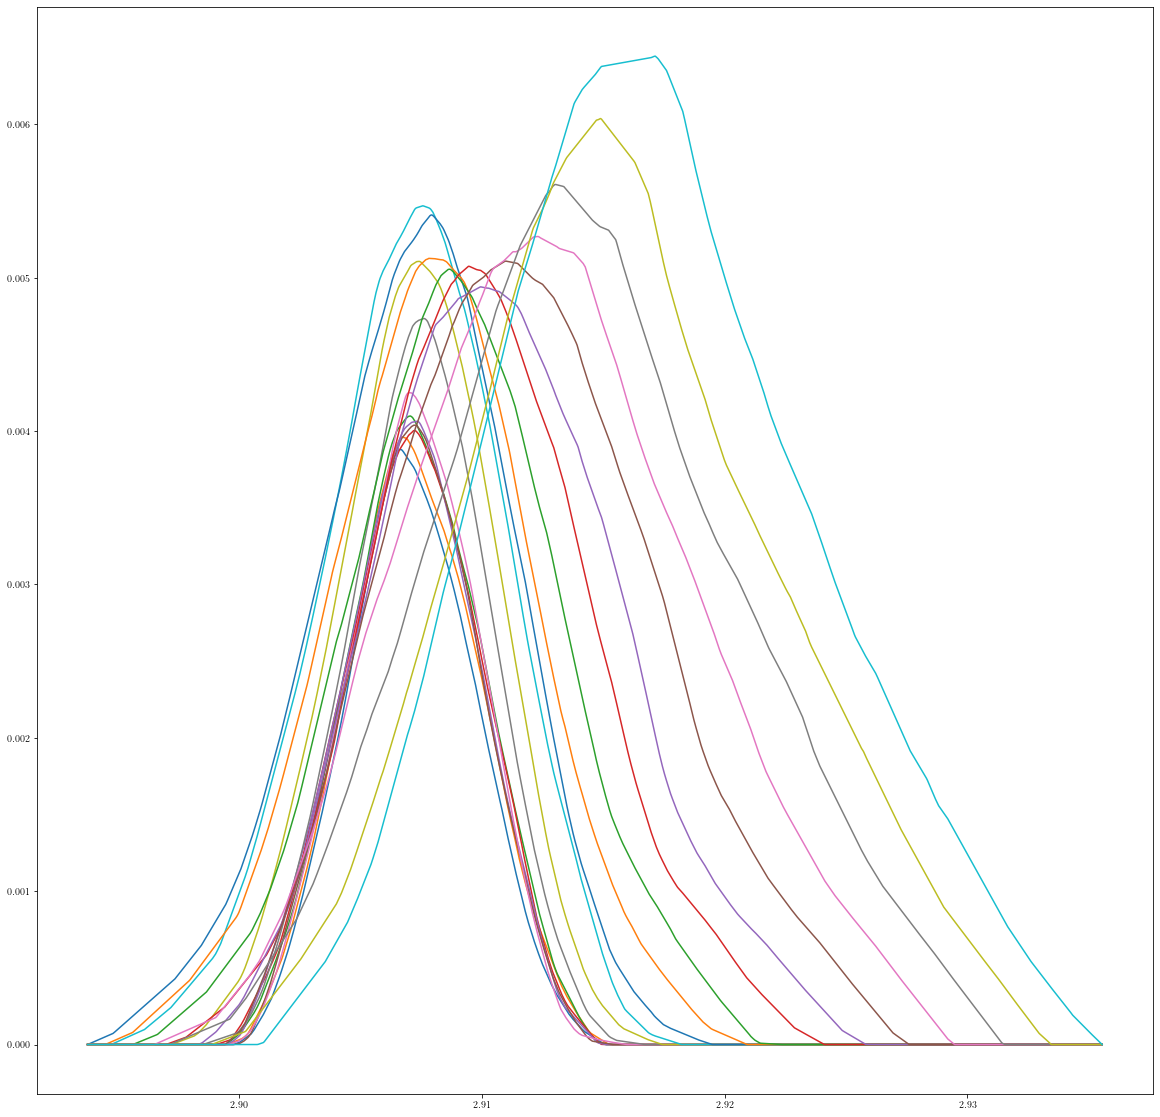

In [224]:
SH = gd.representations.vector_methods.Silhouette(resolution=1000, weight=lambda x: np.power(x[1]-x[0],1))#Landscape(num_landscapes=100, resolution=1000, sample_range=(start,end))#PersistenceImage()
SH.fit(pds)
sh = SH.transform(pds)
#pis=betti_curves
f,ax = plt.subplots(figsize=(20,20))
for i in range(0,len(pds)-1):
    ax.plot(x,sh[i])#,color=t[i])
plt.show()

In [225]:
pis = betti_curves
#pis=sh

Next, we use MDS to visualize the data set in two dimensions.

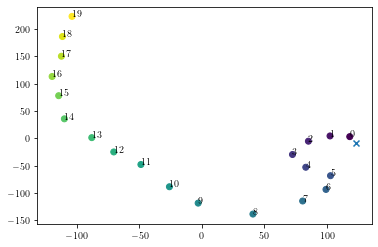

In [227]:
mds = MDS(n_components=2)
emb =mds.fit_transform(pis)
f,ax = plt.subplots()

t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):
    
    ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")

#ax.legend()

#plt.savefig("data221214_alpha18_MDS-from-PI_density_dim{}_delay{}.pdf".format(dim, delay))
plt.show()

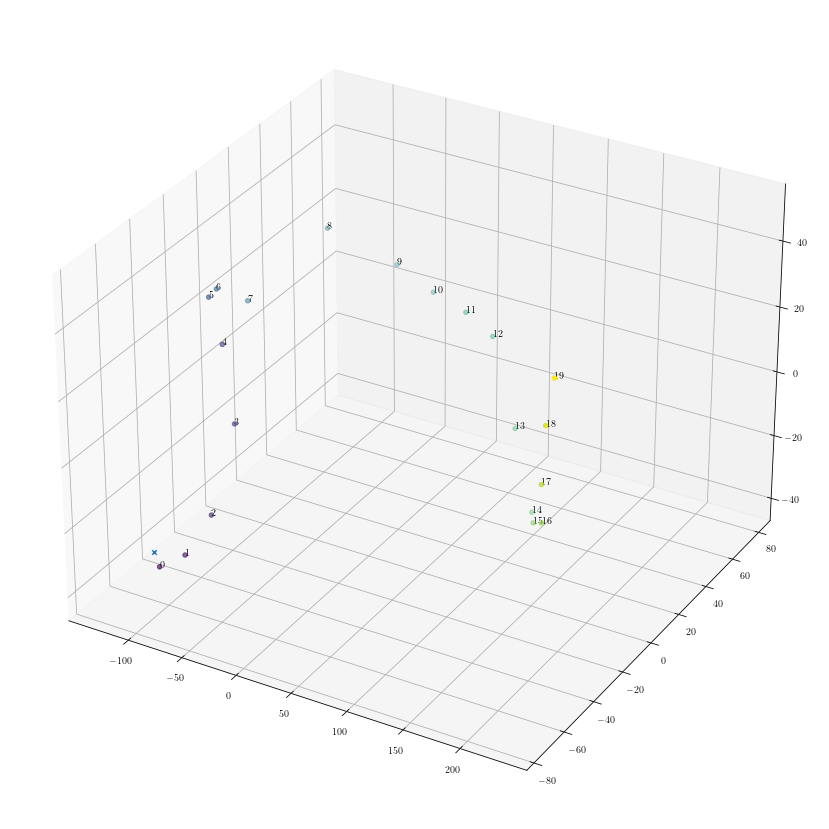

[0.77827433 0.13931876 0.0327453 ]


In [228]:

pca = PCA(n_components=3)
emb = pca.fit_transform(pis)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], emb[:-1,2], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):    
    #ax.scatter(emb[i,0],emb[i,1], emb[i,2], marker = "o", c=t[i], label="malfunctioning machine {}".format(i))
    ax.text(emb[i,0],emb[i,1], emb[i,2],"{}".format(i))

ax.scatter(emb[-1,0],emb[-1,1], emb[-1,2], marker = "x", label="well-working machine")

#ax.legend()
#plt.savefig("data221214_alpha18_PCA-from-PI_dim{}_delay{}.pdf".format(dim, delay))
plt.show()
print(pca.explained_variance_ratio_)

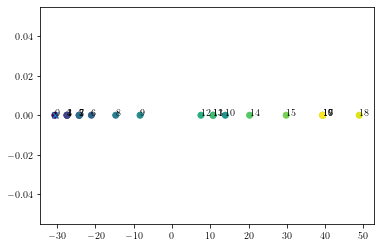

In [118]:
f,ax = plt.subplots()

t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],[0]*(len(emb)-1), marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):
    
    ax.annotate("{}".format(i),(emb[i,0],0))

ax.scatter(emb[-1,0],[0], marker = "x", label="well-working machine")

#ax.legend()
#plt.savefig("data221214_alpha18_PCA-from-PI_dim{}_delay{}.pdf".format(dim, delay))
plt.show()

In [122]:
#WD = gd.representations.WassersteinDistance(order=2, internal_p=2, n_jobs = -1)
WD = gd.representations.BottleneckDistance(n_jobs = -1)
dist_matrix = WD.fit_transform(pds)

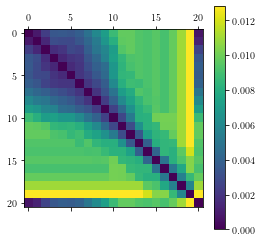

In [123]:
plt.matshow(dist_matrix)
plt.colorbar()
#plt.savefig("data221214_alpha18_W2_dim{}_delay{}.pdf".format(dim,delay))

c:\Users\Niklas\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


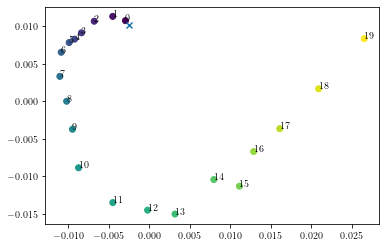

In [124]:
mds = MDS(n_components=2, metric = "precomputed")
emb =mds.fit_transform(dist_matrix)
f,ax = plt.subplots()
t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):
    
    ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")
#ax.legend()
#plt.savefig("data221214_alpha18_MDS-from-W2_dim{}_delay{}.pdf".format(dim, delay))
plt.show()

In [ ]:
reducer = umap.UMAP(metric= "precomputed")
emb = reducer.fit_transform(dist_matrix)

c:\Users\Niklas\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


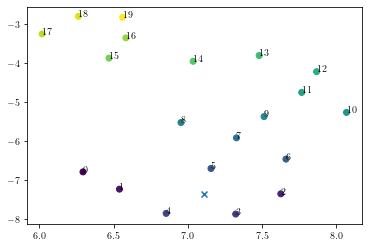

In [ ]:
f,ax = plt.subplots()
t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):
    
    ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")
#ax.legend()
plt.show()

In [ ]:
np.arange(len(data[0]))[data[-2]-data[-1]>4]

array([   41,    42,    46,    47,    51,   874,   875,   879,   880,
         884,  1707,  1708,  1712,  1713,  1717,  2540,  2541,  2545,
        2546,  2550,  3373,  3374,  3378,  3379,  3383,  4206,  4207,
        4211,  4212,  4216,  5039,  5040,  5044,  5045,  5049,  5872,
        5873,  5877,  5878,  5882,  6705,  6706,  6710,  6711,  6715,
        7538,  7539,  7543,  7544,  7548,  8371,  8372,  8376,  8377,
        8381,  9204,  9205,  9209,  9210,  9214, 10037, 10038, 10042,
       10043, 10047, 10870, 10871, 10875, 10876, 10880, 11703, 11704,
       11708, 11709, 11713, 12536, 12537, 12541, 12542, 12546, 13369,
       13370, 13374, 13375, 13379, 14202, 14203, 14207, 14208, 14212,
       15035, 15036, 15040, 15041, 15045, 15868, 15869, 15873, 15874,
       15878, 16701, 16702, 16706, 16707, 16711, 17534, 17535, 17539,
       17540, 17544, 18367, 18368, 18372, 18373, 18377, 19200, 19201,
       19205, 19206, 19210, 20033, 20034, 20038, 20039, 20043, 20866,
       20867, 20871,